In [1]:
import sys
import subprocess

subprocess.check_call([sys.executable, "-m", "pip", "install", "milankalkenings==0.1.42"])

import matplotlib.pyplot as plt
from typing import List, Tuple
import torch
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage
from milankalkenings.visualization import images_subplot


def grad_to_cam(grad: torch.Tensor) -> torch.Tensor:
    return torch.max(grad.abs(), dim=0).values


def min_max_scale(tensor: torch.Tensor) -> torch.Tensor:
    min_val = torch.min(tensor)
    max_val = torch.max(tensor)
    return (tensor - min_val) / (max_val - min_val)


def calc_grad(
        module: torch.nn.Module,
        input: torch.Tensor,
        class_id: int) -> Tuple[torch.Tensor, float]:
    input.requires_grad_(True)
    input.grad = None  # avoid gradient accumulation
    class_prob = module(input)[0][class_id]  # forward pass
    class_prob.backward()  # populate gradients
    return input.grad.data, class_prob.item()


def smooth_grad(
        module: torch.nn.Module,
        image_tensor: torch.Tensor,
        class_id: int,
        n: int,
        noise_level: float) \
        -> Tuple[torch.Tensor, float]:
    sum_grad = torch.zeros(size=image_tensor.shape)
    sum_prob = 0
    for _ in range(n):
        image_tensor_noisy = image_tensor + noise_level * torch.rand(size=image_tensor.shape)
        iter_grad, class_prob = calc_grad(module=module,
                                          input=image_tensor_noisy,
                                          class_id=class_id)
        sum_grad += iter_grad
        sum_prob += class_prob
    grad = torch.squeeze(sum_grad / n)
    prob = sum_prob / n
    return grad_to_cam(grad=torch.squeeze(grad)), prob


def mask(tensor: torch.Tensor, thresh: float) -> torch.Tensor:
    return tensor > thresh


def greater_zero_or_none(tensor: torch.Tensor) -> torch.Tensor:
    if tensor is not None:
        return mask(tensor=tensor, thresh=0).int() * tensor


def non_zero_box(tensor: torch.Tensor) -> Tuple[List[float], List[float]]:
    """

    :param tensor: 2d tensor
    :return: coordinates: (top_left, bottom_right)
    """
    nonzero_indices = torch.nonzero(tensor)
    co = []
    for i in range(2):
        co.append(torch.min(nonzero_indices[:, i]).item())
        co.append(torch.max(nonzero_indices[:, i]).item())
    return [co[0], co[2]], [co[1], co[3]]


def draw_rectangle(
        shape: List[int],
        value: float,
        top_left: List[torch.Tensor],
        bottom_right: List[torch.Tensor]) -> torch.Tensor:
    rectangle = torch.zeros(size=shape)
    rectangle[top_left[0], top_left[1]:bottom_right[1] + 1] = value
    rectangle[bottom_right[0], top_left[1]:bottom_right[1] + 1] = value
    rectangle[top_left[0]:bottom_right[0] + 1, top_left[1]] = value
    rectangle[top_left[0]:bottom_right[0] + 1, bottom_right[1]] = value
    return rectangle


def rectify_hook(
        module: torch.nn.Module,
        grad_inputs: torch.Tensor,
        grad_outputs: torch.Tensor):
    new_grad_inputs = tuple([greater_zero_or_none(gi) for gi in grad_inputs])
    return new_grad_inputs


def process_cams(cams: List[torch.Tensor], enhance: float) -> torch.Tensor:
    cams.append(torch.zeros_like(cams[-1]))
    return min_max_scale(torch.cat(cams)) * enhance

In [2]:
# parameters
image_path = "../../data/imagenet/dog_cat.jpeg"
monitoring_path = "../../monitoring/smoothgrad"
image_size = 256
smoothgrad_n = 50  # up to 50 is recommended by the authors
noise_level = 1
thresh = 0.2
mask_step = 4
enhance_factor = 4

In [3]:
# load data
to_tensor = Compose([Resize(size=image_size), ToTensor()])
image = Image.open(image_path)
image_tensor = to_tensor(image)
image_batch = torch.unsqueeze(image_tensor, dim=0)

# load model
resnet = resnet50(ResNet50_Weights.IMAGENET1K_V2).eval()

# determine top softmax output
top_ids = torch.topk(input=resnet(image_batch), k=2).indices[0]
print(f"top 2 class ids:", top_ids)

C:\Users\milan\anaconda3\envs\small_projects\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(


top 2 class ids: tensor([207, 281])


https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a#file-imagenet1000_clsidx_to_labels-txt
207: 'golden retriever'
281: 'tabby, tabby cat'

In [4]:
# CAM
# gradient of the class score w.r.t. the non-noisy input
cams = []
for class_id in top_ids:
    cam, _ = smooth_grad(
        module=resnet,
        image_tensor=image_batch,
        n=1,
        noise_level=0,
        class_id=class_id)
    cams.append(torch.unsqueeze(cam, dim=0))
cams = process_cams(cams=cams, enhance=enhance_factor)

In [5]:
# SmoothGrad
# average over the gradient of the class score w.r.t. $n$ noisy versions of the input
cams_smoothgrad = []
for class_id in top_ids:
    cam, _ = smooth_grad(
        module=resnet,
        image_tensor=image_batch,
        n=smoothgrad_n,
        noise_level=noise_level,
        class_id=class_id)
    cams_smoothgrad.append(torch.unsqueeze(cam, dim=0))
cams_smoothgrad = process_cams(cams=cams_smoothgrad, enhance=enhance_factor)

In [6]:
# guided CAM
# only propagate positive gradients back
for module in resnet.modules():
    module.register_backward_hook(rectify_hook)
cams_guided = []
for class_id in top_ids:
    cam, _ = smooth_grad(
        module=resnet,
        image_tensor=image_batch,
        n=1,
        noise_level=0,
        class_id=class_id)
    cams_guided.append(torch.unsqueeze(cam, dim=0))
cams_guided = process_cams(cams=cams_guided, enhance=enhance_factor)

C:\Users\milan\anaconda3\envs\small_projects\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [7]:
# build naive bounding boxes from guided CAM
# only keep max value per pixel
# if not done, then bounding boxes either too small or too big
# depending on thresh
mask_max_only = torch.eq(cams_guided, torch.max(cams_guided, dim=0)[0])
cams_guided_rel = cams_guided * mask_max_only

# focus on the most confidant only
cams_guided_threshed = mask(
    tensor=cams_guided_rel,
    thresh=thresh) * cams_guided_rel

rectangles = []
for j in range(2):
    top_left, bottom_right = non_zero_box(tensor=cams_guided_threshed[j])
    rectangles.append(torch.unsqueeze(draw_rectangle(
        shape=list(cams_guided_threshed[j].shape),
        value=torch.max(cams_guided_threshed).item(),
        top_left=top_left,
        bottom_right=bottom_right),
        dim=0))
rectangles.append(torch.zeros_like(rectangles[0]))
rectangles = torch.cat(rectangles)

cams_guided[rectangles == 1] = 0
cams_guided = cams_guided + rectangles

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


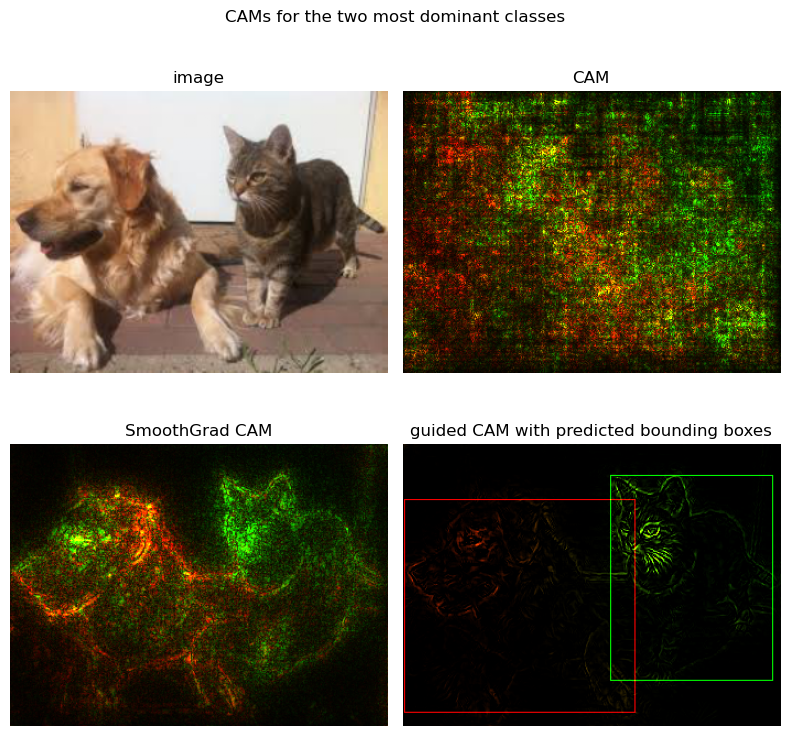

In [8]:
images_subplot(
    images=[image_tensor,
            cams,
            cams_smoothgrad,
            cams_guided],
    title="CAMs for the two most dominant classes",
    subplot_titles=["image",
                    "CAM",
                    "SmoothGrad CAM",
                    f"guided CAM with predicted bounding boxes"],
    save_file=monitoring_path + "/benchmark")

In [9]:
# create growing rectangular mask for the golden retriever
# & monitor class scores
# create frames for a gif
masking_path = monitoring_path + "/masking"
frames_path = masking_path + "/gif_images"
masking_image_batch = image_batch.clone()
to_image = ToPILImage()
probs = []
arange = torch.arange(start=0, step=mask_step, end=masking_image_batch.shape[2] + mask_step)
for i, j in enumerate(arange):
    masking_image_batch[0, :, -j:, :j] = 0
    cams_iter = []
    for class_id in top_ids:
        cam, prob = smooth_grad(
            module=resnet,
            image_tensor=masking_image_batch,
            n=1,
            noise_level=0,
            class_id=class_id)
        cams_iter.append(torch.unsqueeze(cam, dim=0))
        probs.append(prob)
    cams_iter = process_cams(cams=cams_iter, enhance=enhance_factor)
    cams_iter[:, -j:, :j] = torch.max(cams_iter)
    to_image(cams_iter).save(frames_path + f"/iter_{int(i)}.png")

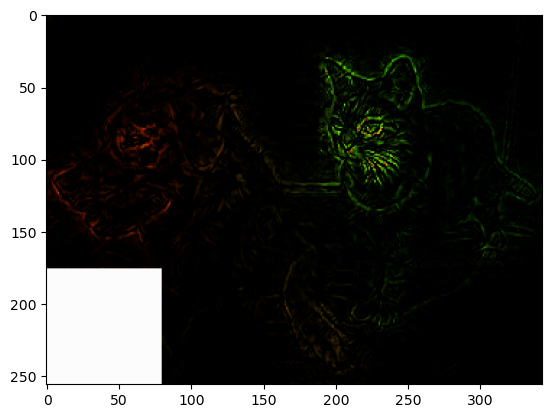

In [14]:
plt.imshow(Image.open(frames_path + f"/iter_20.png"))
plt.show()

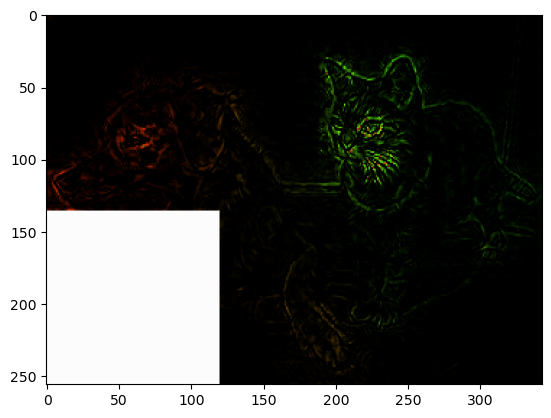

In [16]:
plt.imshow(Image.open(frames_path + f"/iter_30.png"))
plt.show()

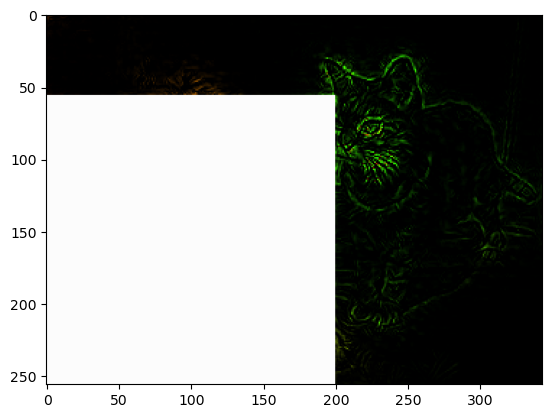

In [17]:
plt.imshow(Image.open(frames_path + f"/iter_50.png"))
plt.show()

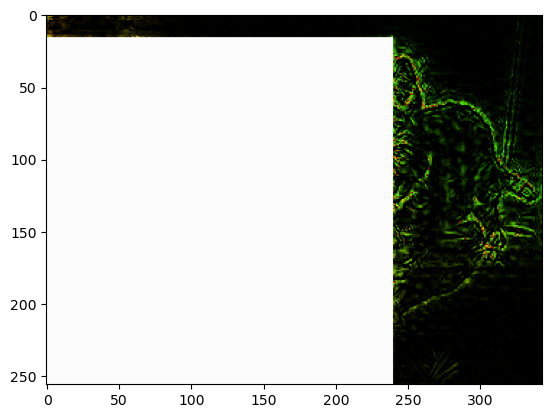

In [18]:
plt.imshow(Image.open(frames_path + f"/iter_60.png"))
plt.show()

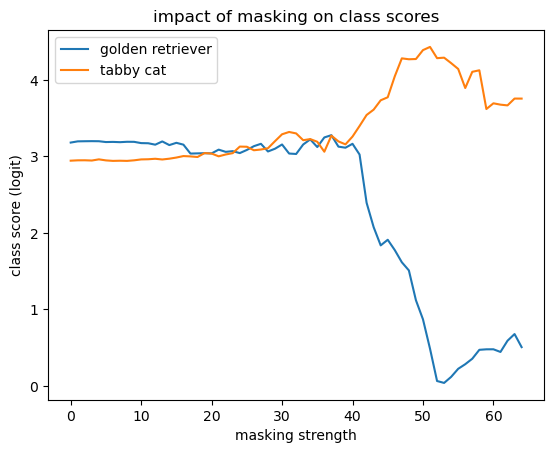

In [19]:
# plot the class scores of the two most dominant classes
plt.clf()
probs_cls_0 = probs[::2]
probs_cls_1 = probs[1::2]
plt.plot(range(len(probs_cls_0)), probs_cls_0, label="golden retriever")
plt.plot(range(len(probs_cls_1)), probs_cls_1, label="tabby cat")
plt.ylabel("class score (logit)")
plt.xlabel("masking strength")
plt.title("impact of masking on class scores")
plt.legend()
plt.savefig(masking_path + "/probs")

### what happens if we gradually mask out the golden retriever?
- information that contradicts prediction *tabby cat* is left out, so class score for it increases
- information that supports prediction *golden retriever* is left out, so class score for it decreases